C:\Users\fahds\AppData\Local\Temp\ipykernel_92324\456577726.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")


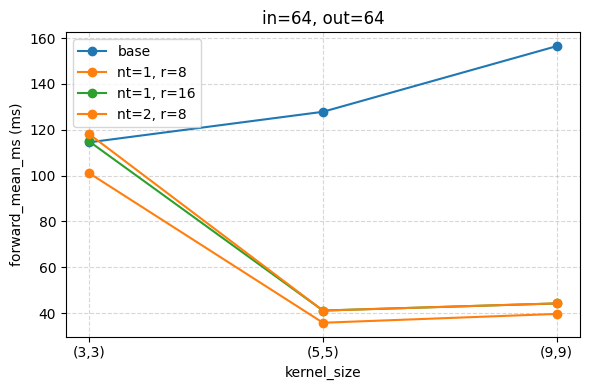

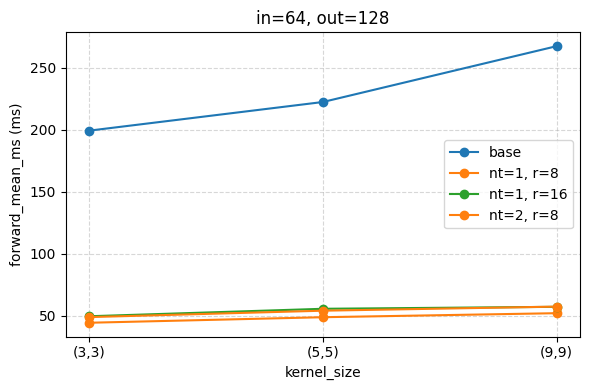

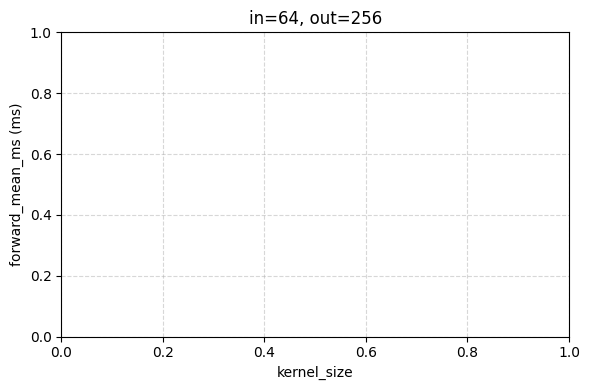

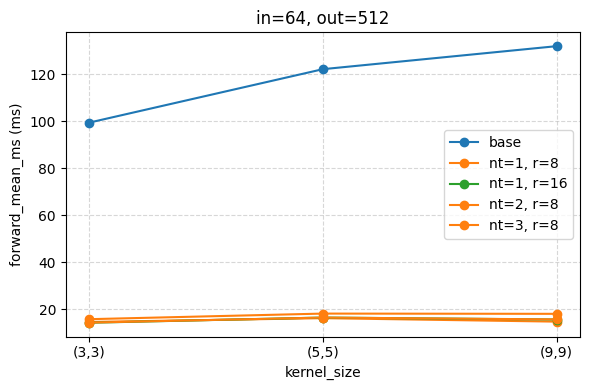

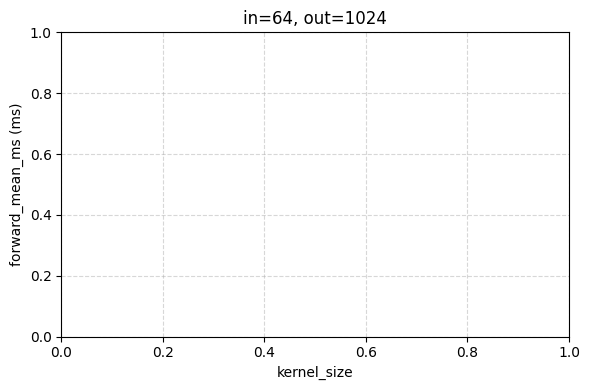

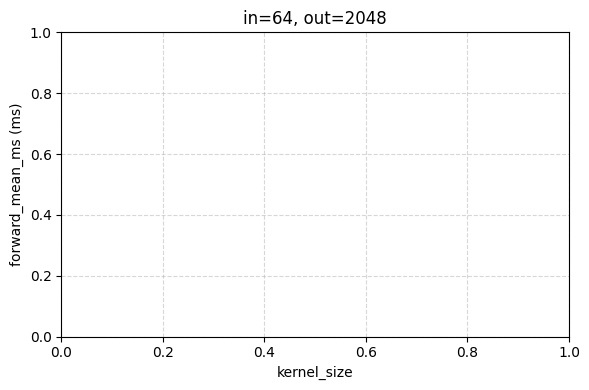

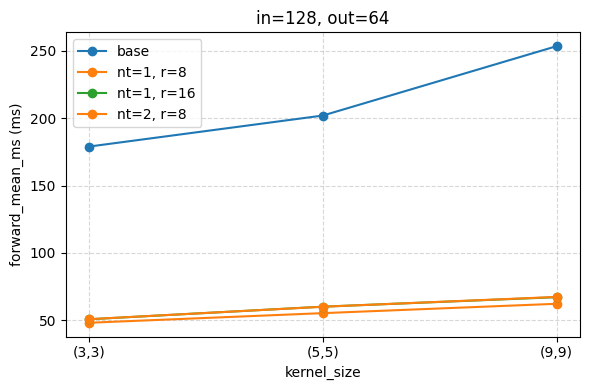

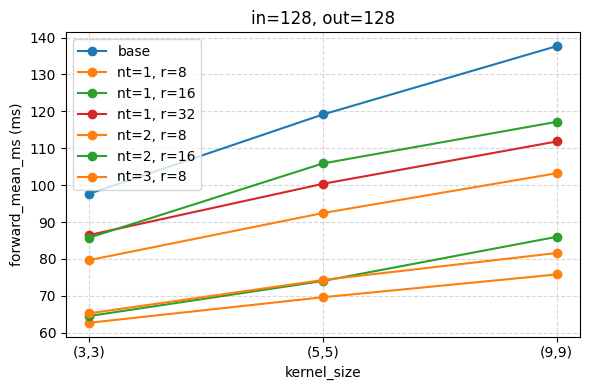

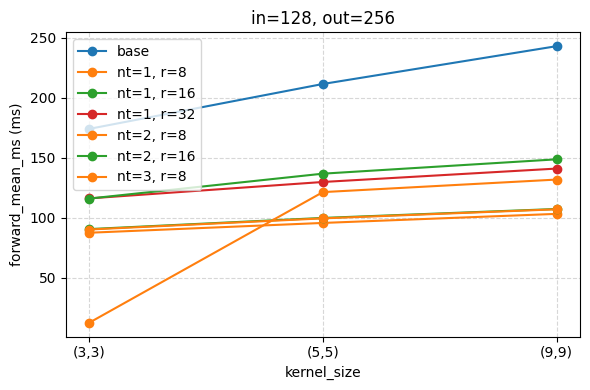

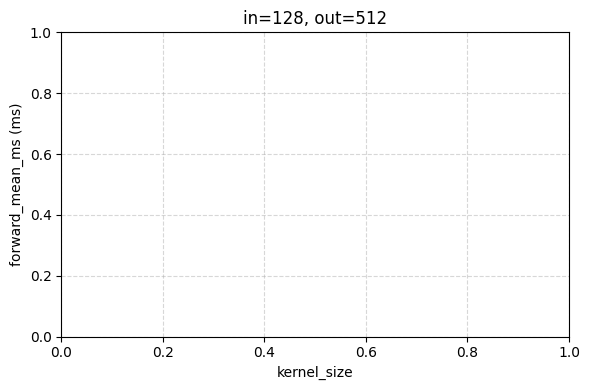

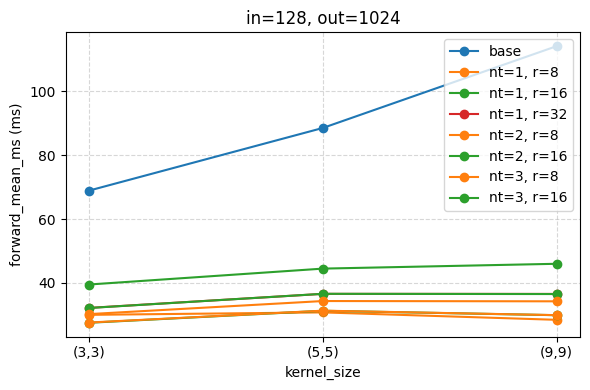

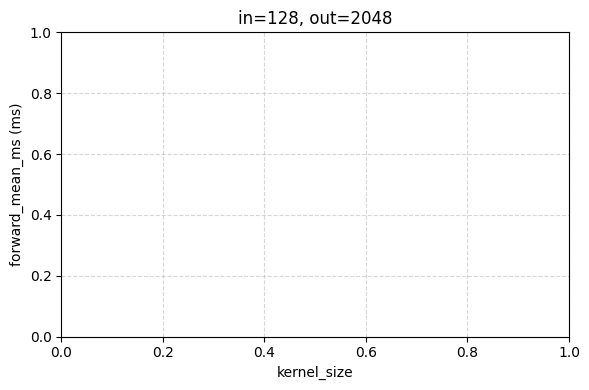

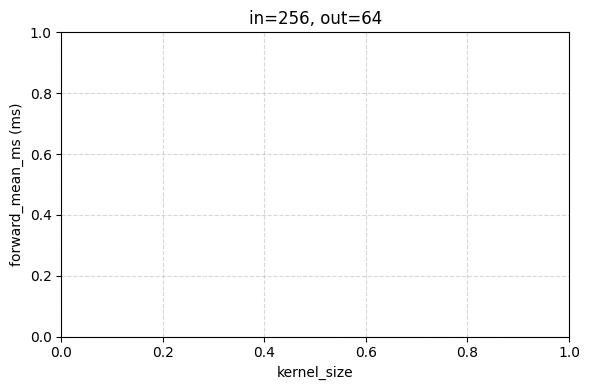

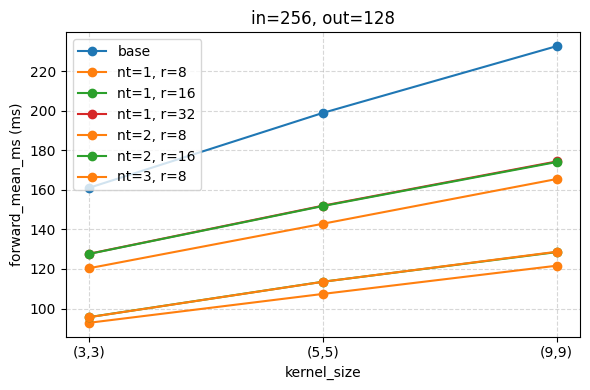

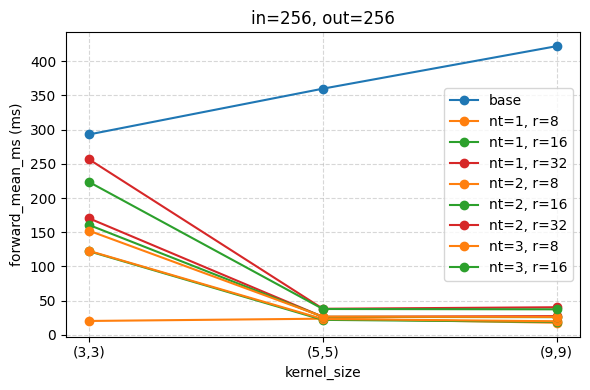

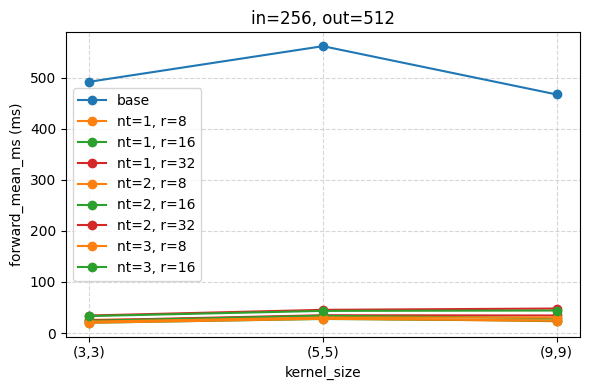

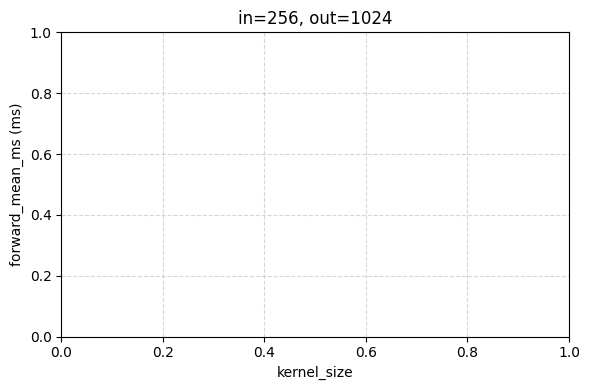

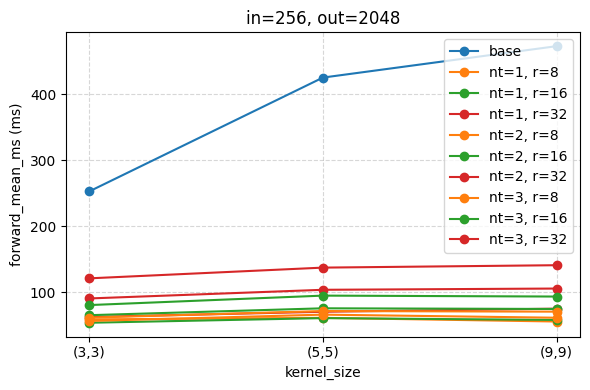

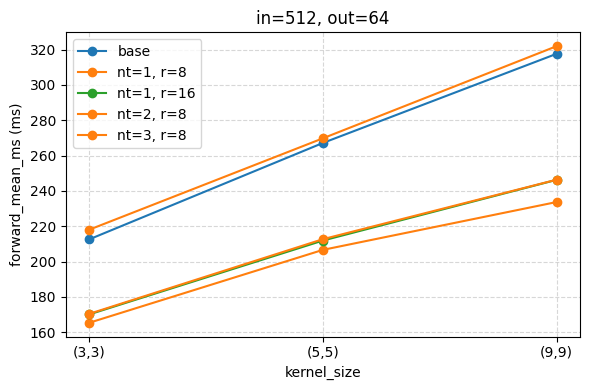

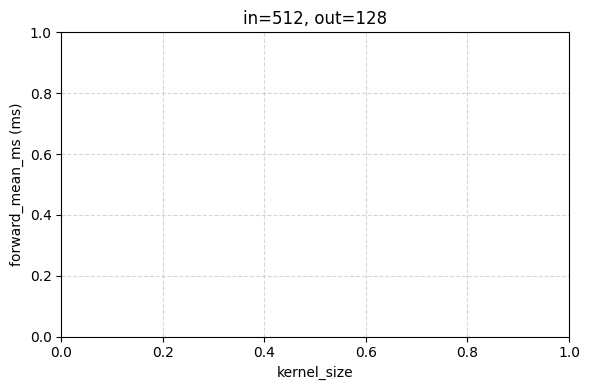

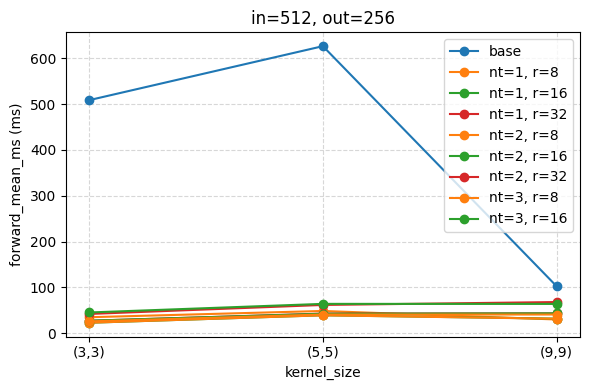

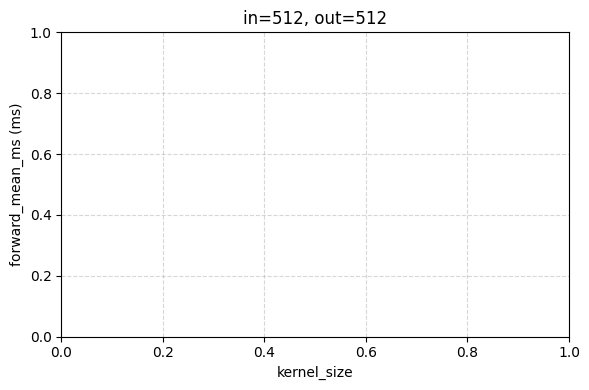

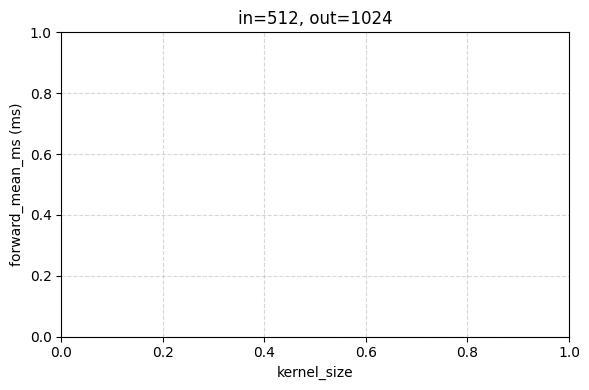

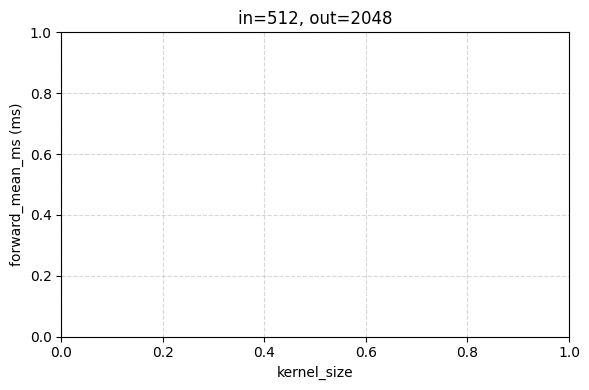

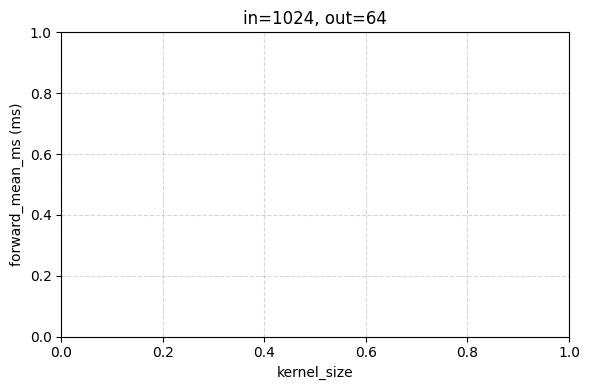

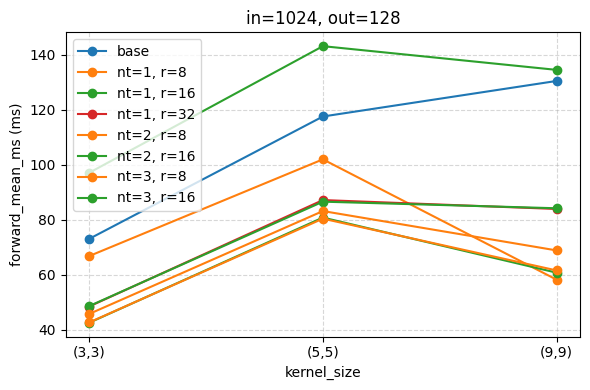

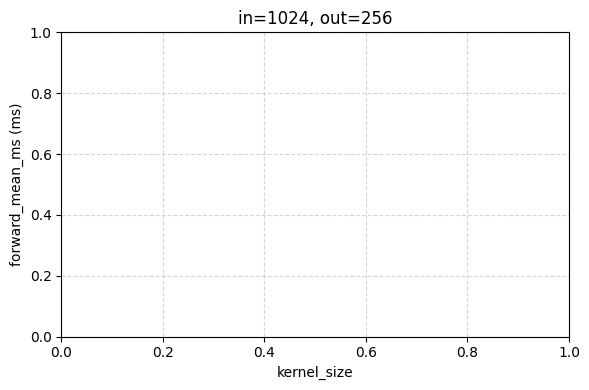

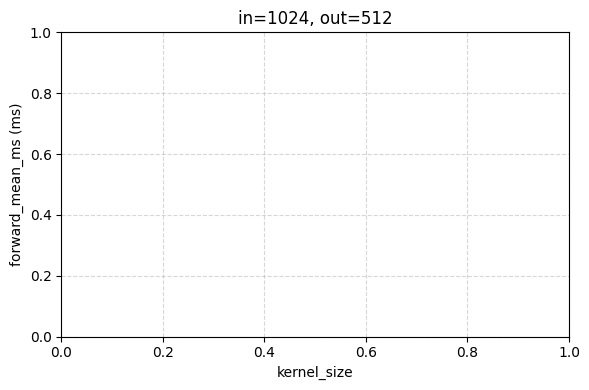

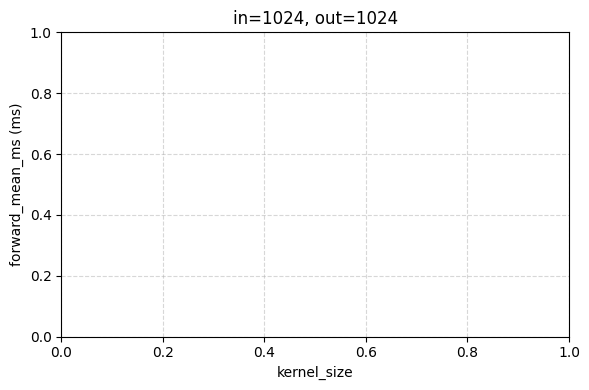

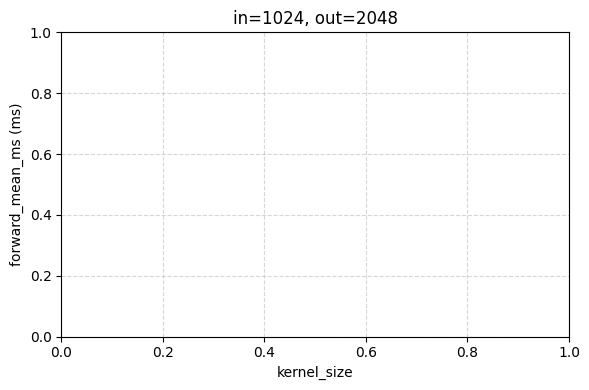

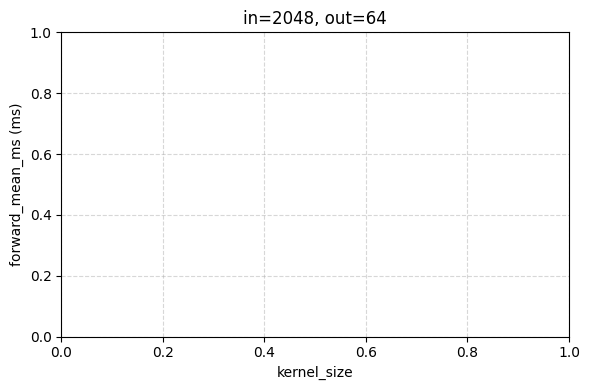

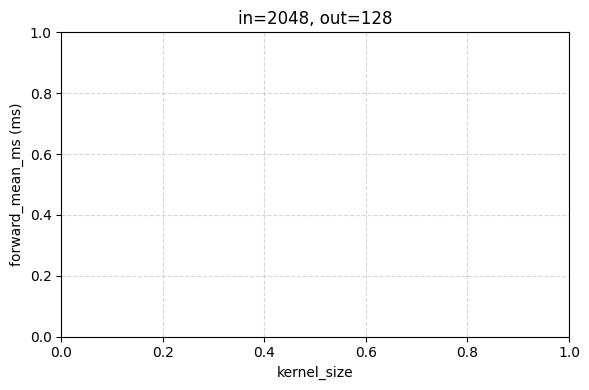

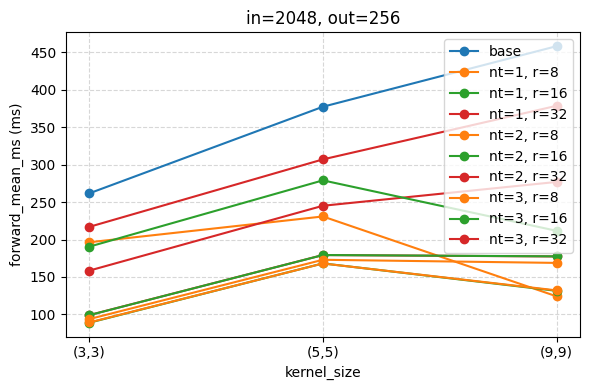

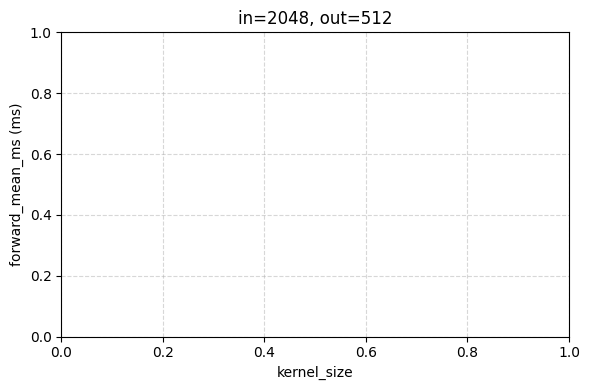

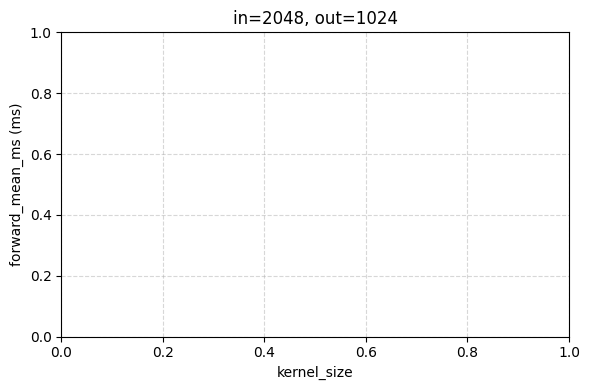

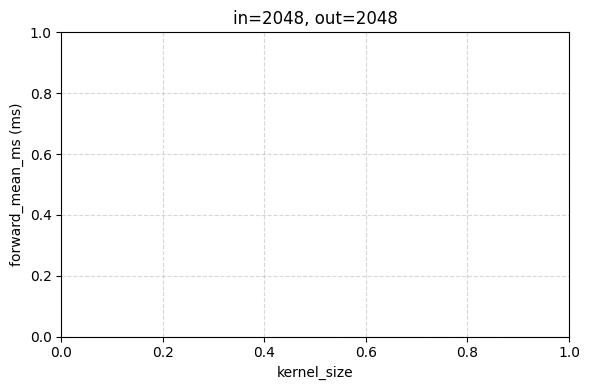

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.cm import get_cmap

# === Configuration ===
CSV_FILE = "results_conv.csv"  # Combined CSV file path
BASE_MODEL = "nn.Conv2d"  # Baseline model name
METRIC = "forward_mean_ms"  # Metric to plot (e.g., forward_mean_ms or backward_mean_ms)
VARIATE = "kernel_size"  # Axis to vary: 'kernel_size' or 'dimension'

# Plot mode toggles
USE_GRID = False  # True: grid layout for all in/out combinations
ALL_IN_ONE = False  # If grid, draw all subplots in a single figure

# Legend and layout
TIGHT_RECT = [0, 0, 1, 0.95]

# === Load & preprocess ===


def load_and_clean(path):
    df = pd.read_csv(path)
    return df.dropna(subset=[METRIC])


df = load_and_clean(CSV_FILE)

# Identify unique variants (num_terms, low_rank)
tweaks = (
    df[df["model"] != BASE_MODEL][["num_terms", "low_rank"]]
    .drop_duplicates()
    .sort_values(["num_terms", "low_rank"])
    .values.tolist()
)
unique_lrs = sorted({lr for nt, lr in tweaks})

# Color mapping
cmap = get_cmap("tab10")
grid_colors = {lr: cmap(i + 1) for i, lr in enumerate(unique_lrs)}
base_color = cmap(0)

# Helper to retrieve metric per grouping


def fetch_metric(subdf, in_c, out_c, var_val, nt=None, lr=None):
    cond = (
        (subdf["in_channels"] == in_c)
        & (subdf["out_channels"] == out_c)
        & (subdf[VARIATE] == var_val)
    )
    if nt is not None and lr is not None:
        cond &= (subdf["num_terms"] == nt) & (subdf["low_rank"] == lr)
    else:
        cond &= subdf["model"] == BASE_MODEL
    subset = subdf[cond]
    if subset.empty:
        return None
    return subset[METRIC].mean()


# Main plotting
in_chs = sorted(df["in_channels"].unique())
out_chs = sorted(df["out_channels"].unique())
var_values = sorted(df[VARIATE].unique())
pairs = [(i, o) for o in out_chs for i in in_chs]

if USE_GRID:
    n_r, n_c = len(out_chs), len(in_chs)
    fig, axes = plt.subplots(n_r, n_c, figsize=(4 * n_c, 3 * n_r))
    fig.suptitle(f"Trend of {METRIC} vs {VARIATE}")
    for ax, (in_c, out_c) in zip(axes.flat, pairs):
        # baseline
        y_base = [fetch_metric(df, in_c, out_c, v) for v in var_values]
        if any(val is not None for val in y_base):
            ax.plot(var_values, y_base, marker="o", color=base_color, label="base")
        # variants
        for nt, lr in tweaks:
            y_vals = [
                fetch_metric(df[df["model"] != BASE_MODEL], in_c, out_c, v, nt, lr)
                for v in var_values
            ]
            if any(val is not None for val in y_vals):
                ax.plot(
                    var_values,
                    y_vals,
                    marker="o",
                    color=grid_colors[lr],
                    label=f"nt={nt}, r={lr}",
                )
        ax.set_title(f"in={in_c}, out={out_c}")
        ax.set_xlabel(VARIATE)
        ax.set_ylabel(f"{METRIC} (ms)")
        ax.grid(True, linestyle="--", alpha=0.5)
        if ax.get_legend_handles_labels()[0]:
            ax.legend(loc="best")
    plt.tight_layout(rect=TIGHT_RECT)
    plt.show()
else:
    # standalone plots
    for in_c in in_chs:
        for out_c in out_chs:
            fig, ax = plt.subplots(figsize=(6, 4))
            y_base = [fetch_metric(df, in_c, out_c, v) for v in var_values]
            if any(val is not None for val in y_base):
                ax.plot(var_values, y_base, marker="o", color=base_color, label="base")
            for nt, lr in tweaks:
                y_vals = [
                    fetch_metric(df[df["model"] != BASE_MODEL], in_c, out_c, v, nt, lr)
                    for v in var_values
                ]
                if any(val is not None for val in y_vals):
                    ax.plot(
                        var_values,
                        y_vals,
                        marker="o",
                        color=grid_colors[lr],
                        label=f"nt={nt}, r={lr}",
                    )
            ax.set_title(f"in={in_c}, out={out_c}")
            ax.set_xlabel(VARIATE)
            ax.set_ylabel(f"{METRIC} (ms)")
            ax.grid(True, linestyle="--", alpha=0.5)
            if ax.get_legend_handles_labels()[0]:
                ax.legend(loc="best")
            plt.tight_layout()
            plt.show()